In [10]:
from google.colab import drive
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# --- 1. Connect to Google Drive ---
# This will prompt for authorization from your Google Account.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# --- 2. Load the Dataset from Google Drive ---
# IMPORTANT: You must update the file path to match where the file is located in your Google Drive.
# For example, if your file is in a folder called 'Colab_Data', the path would be:
# file_path = '/content/drive/My Drive/Colab_Data/customer_transactions.csv'
file_path = '/content/drive/My Drive/market_basket_analysis/customer_transactions.csv' # <-- UPDATE THIS PATH

df = pd.read_csv(file_path)

print("Successfully loaded the dataset!")

# --- 3. Data Preprocessing ---
# Convert the 'items' string into a list of items
df['items'] = df['items'].apply(lambda x: x.split(', '))

Successfully loaded the dataset!


In [12]:
# --- 4. One-Hot Encoding ---
# Transform the data into a one-hot encoded format for the Apriori algorithm
te = TransactionEncoder()
te_ary = te.fit(df['items']).transform(df['items'])
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

In [13]:
# --- 5. Association Rule Mining ---
# Find frequent itemsets with a minimum support of 1%
frequent_itemsets = apriori(df_onehot, min_support=0.01, use_colnames=True)

# Generate association rules with a minimum lift of 1
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [14]:
# --- 6. Display and Save Results ---
# Sort the rules by 'lift' to see the strongest associations
top_10_rules = rules.sort_values(by='lift', ascending=False).head(10)

print("\nTop 10 Association Rules:")
print(top_10_rules)


Top 10 Association Rules:
      antecedents   consequents  antecedent support  consequent support  \
17    (Product_8)   (Product_1)            0.109167            0.092500   
16    (Product_1)   (Product_8)            0.092500            0.109167   
161   (Product_3)  (Product_18)            0.101667            0.102500   
160  (Product_18)   (Product_3)            0.102500            0.101667   
9    (Product_15)   (Product_1)            0.111667            0.092500   
8     (Product_1)  (Product_15)            0.092500            0.111667   
194   (Product_9)   (Product_2)            0.098333            0.095000   
195   (Product_2)   (Product_9)            0.095000            0.098333   
172  (Product_27)  (Product_19)            0.105000            0.089167   
173  (Product_19)  (Product_27)            0.089167            0.105000   

      support  confidence      lift  representativity  leverage  conviction  \
17   0.018333    0.167939  1.815556               1.0  0.008235    1

In [16]:
# --- 7. Save Results back to Google Drive ---
# This will save the full list of rules to a new CSV file in your drive
output_path = '/content/drive/My Drive/market_basket_analysis/association_rules.csv' # <-- You can change this save path
rules.to_csv(output_path, index=False)

print(f"\n✅ Association rules successfully saved to: {output_path}")


✅ Association rules successfully saved to: /content/drive/My Drive/market_basket_analysis/association_rules.csv


In [18]:
# ==============================================================================
# 1. SETUP AND DATA LOADING
# ==============================================================================
# Import necessary libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from google.colab import drive

# Convert 'transaction_date' column to datetime objects.
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

print("Step 1: Setup and data loading complete.")
print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

Step 1: Setup and data loading complete.
Dataset has 1200 rows and 5 columns.


In [19]:
# ==============================================================================
# 2. RFM (RECENCY, FREQUENCY, MONETARY) ANALYSIS
# ==============================================================================
# Create a customer-level dataframe for RFM features.

# Set the snapshot date for recency calculation.
snapshot_date = df['transaction_date'].max() + dt.timedelta(days=1)

# Calculate Recency: Days since each customer's last purchase.
recency_df = df.groupby('customer_id').agg({
    'transaction_date': lambda x: (snapshot_date - x.max()).days
}).rename(columns={'transaction_date': 'Recency'})

# Calculate Frequency: Count of transactions per customer.
frequency_df = df.groupby('customer_id').agg({
    'transaction_id': 'count'
}).rename(columns={'transaction_id': 'Frequency'})

# Calculate Monetary: Sum of purchase amounts per customer.
monetary_df = df.groupby('customer_id').agg({
    'amount': 'sum'
}).rename(columns={'amount': 'Monetary'})

# Combine RFM features into a single dataframe.
rfm_df = recency_df.join(frequency_df).join(monetary_df)

print("\nStep 2: RFM analysis complete.")
print("RFM DataFrame head:")
print(rfm_df.head())


Step 2: RFM analysis complete.
RFM DataFrame head:
             Recency  Frequency  Monetary
customer_id                              
CUST_001          20          7   1762.86
CUST_002         261          2    677.88
CUST_003          37          7   2289.11
CUST_004          10          3   1097.26
CUST_005          60          4   1266.58


In [20]:
# ==============================================================================
# 3. DATA PREPROCESSING FOR CLUSTERING
# ==============================================================================
# Scale the RFM features for the clustering algorithm.

# Apply log transformation to reduce data skewness.
rfm_log = np.log1p(rfm_df)

# Standardize the log-transformed data.
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm_df.index, columns=rfm_df.columns)

print("\nStep 3: Data preprocessing complete.")
print("Scaled RFM DataFrame head:")
print(rfm_scaled.head())


Step 3: Data preprocessing complete.
Scaled RFM DataFrame head:
              Recency  Frequency  Monetary
customer_id                               
CUST_001    -0.541174   0.548407  0.542787
CUST_002     1.928072  -2.234172 -1.318938
CUST_003     0.039065   0.548407  1.051878
CUST_004    -1.173819  -1.418028 -0.380997
CUST_005     0.502118  -0.784977 -0.101426


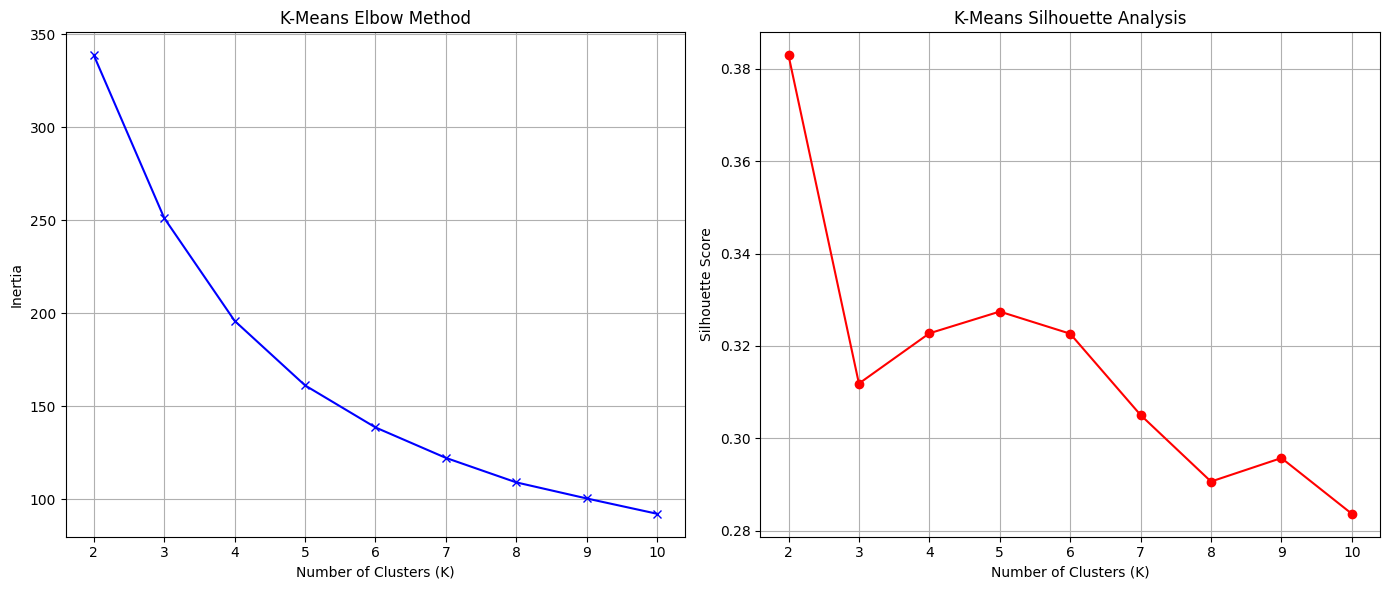


Step 4: Optimal K analysis complete.
ACTION: Choose the optimal K based on the charts above. K=4 is a reasonable starting point.


In [21]:
# ==============================================================================
# 4. FINDING THE OPTIMAL NUMBER OF CLUSTERS (K)
# =-============================================================================
# Use the Elbow Method and Silhouette Analysis to determine the best K for K-Means.

# Calculate inertia for a range of K values.
inertia_scores = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia_scores[k] = kmeans.inertia_

# Calculate silhouette scores for a range of K values.
silhouette_scores = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    silhouette_scores[k] = silhouette_score(rfm_scaled, kmeans.labels_)

# Plot the Elbow Method and Silhouette Analysis results.
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(list(inertia_scores.keys()), list(inertia_scores.values()), 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('K-Means Elbow Method')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), 'ro-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('K-Means Silhouette Analysis')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nStep 4: Optimal K analysis complete.")
print("ACTION: Choose the optimal K based on the charts above. K=4 is a reasonable starting point.")

In [22]:
# ==============================================================================
# 5. K-MEANS CLUSTERING IMPLEMENTATION
# ==============================================================================
# Set the optimal K and run the K-Means algorithm.
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(rfm_scaled)

# Add K-Means cluster labels to the RFM dataframe.
rfm_df['KMeans_Cluster'] = kmeans.labels_

print(f"\nStep 5: K-Means clustering with K={optimal_k} complete.")


Step 5: K-Means clustering with K=5 complete.


In [23]:
# ==============================================================================
# 6. HIERARCHICAL CLUSTERING (ALTERNATIVE ALGORITHM)
# ==============================================================================
# Implement Hierarchical Clustering as the required alternative method.
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(rfm_scaled)

# Add Hierarchical cluster labels to the dataframe.
rfm_df['Hierarchical_Cluster'] = hierarchical_labels

print("\nStep 6: Hierarchical clustering complete.")
print("Final DataFrame with cluster labels:")
print(rfm_df.head())


Step 6: Hierarchical clustering complete.
Final DataFrame with cluster labels:
             Recency  Frequency  Monetary  KMeans_Cluster  \
customer_id                                                 
CUST_001          20          7   1762.86               0   
CUST_002         261          2    677.88               1   
CUST_003          37          7   2289.11               0   
CUST_004          10          3   1097.26               4   
CUST_005          60          4   1266.58               3   

             Hierarchical_Cluster  
customer_id                        
CUST_001                        3  
CUST_002                        2  
CUST_003                        0  
CUST_004                        1  
CUST_005                        1  



--- K-Means Cluster Summary ---
                   Recency  Frequency     Monetary  Customer_Count
KMeans_Cluster                                                    
0                55.420290   7.347826  1816.911884              69
1               103.428571   2.571429   507.290000              21
2                 9.800000   8.571429  2286.844857              35
3               101.309524   4.452381  1068.374286              42
4                17.363636   4.606061  1185.176061              33


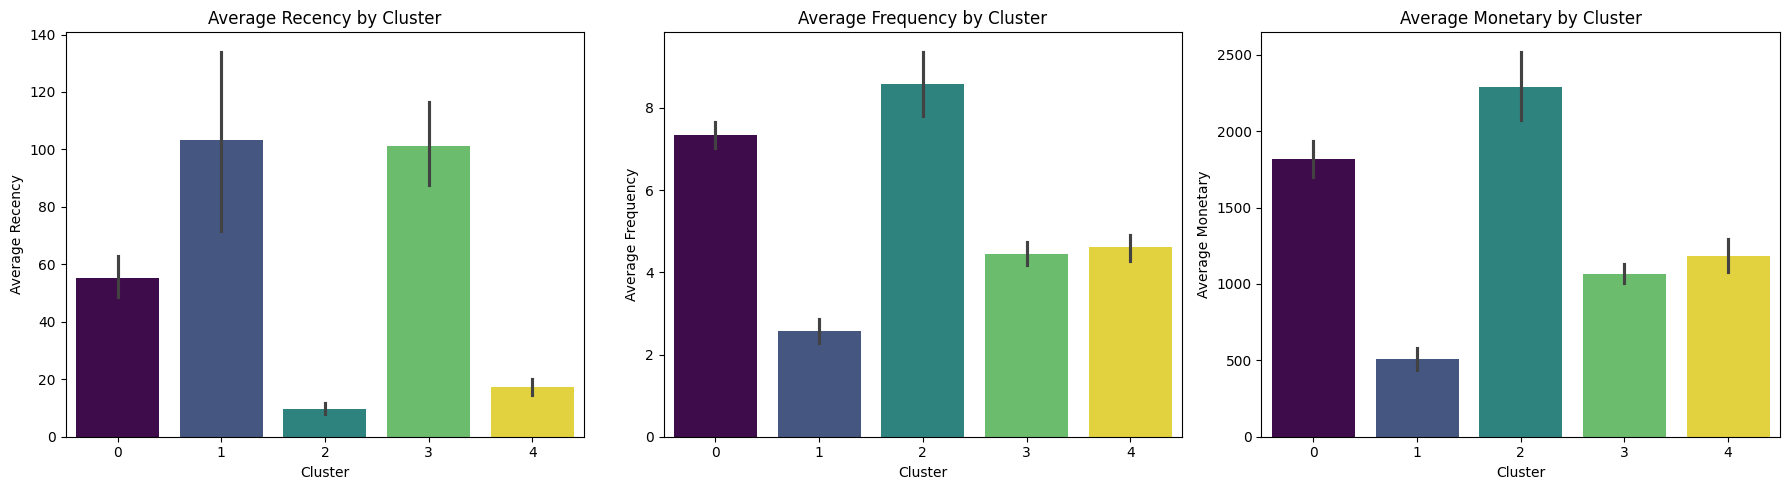


Step 7: Cluster analysis and visualization complete.


In [25]:
# ==============================================================================
# 7. CLUSTER ANALYSIS AND VISUALIZATION
# ==============================================================================
# Analyze and visualize the K-Means segments to understand their characteristics.

# Calculate the mean RFM values for each cluster.
cluster_summary = rfm_df.groupby('KMeans_Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'KMeans_Cluster': 'count'
}).rename(columns={'KMeans_Cluster': 'Customer_Count'})

print("\n--- K-Means Cluster Summary ---")
print(cluster_summary)

# Generate a 3D scatter plot to visualize clusters.
fig = px.scatter_3d(
    rfm_df,
    x='Recency',
    y='Frequency',
    z='Monetary',
    color='KMeans_Cluster',
    symbol='KMeans_Cluster',
    size_max=18,
    opacity=0.7,
    title='3D Scatter Plot of Customer Segments (K-Means)'
)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
fig.show()

# Generate bar plots for each RFM attribute by cluster.
plt.figure(figsize=(18, 5))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1, 3, i+1)
    sns.barplot(x='KMeans_Cluster', y=col, data=rfm_df, palette='viridis', hue='KMeans_Cluster', legend=False)
    plt.title(f'Average {col} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Average {col}')
plt.tight_layout()
plt.show()

print("\nStep 7: Cluster analysis and visualization complete.")
# ACTION: Use the summary table and plots to define customer personas for each cluster.